# Machine Learning for Language Recognition

## Problem Description

We want to design a system for automatically detecting in which language a short text is written. In particular, we want to distinguish between English, French, and Italian.

Some examples:

> The doctor, who was the family physician, saluted him, but he scarcely took any notice. --> English

> J'ai couru chez toi, je ne t'ai plus trouvée, tu sais la parole que je t'avais donnée, je la Bens. --> French

> Conosci tu qualche hossanieh poco scrupoloso che si possa comperare con un bel pugno d'oro? --> Italian

This is a simple, but realistic problem, which we want to solve using a traditional (non deep) Multi Layer Perceptron.

Compared to our dummy example there is **one main difference: each sample in the dataset is a piece of text, rather than a vector of numbers**.

Before we can think of learning a MLP to solve this problem, we need to convert the input in a form that the Neural Network can understand.

The traditonal way to do it is by computing for each piece of text a set of numeric _features_ (e.g. number characters, number of vowels...). By doing so, we associate each example to a feature vector, which can be fed to the MLP.

The main goal of this exercise will be to design a good set of features for the considered problem. We will come to that at the end of the notebook: first, we need to understand how the overall solution approach works.

## First of All...

If you are using this notebook from Google Colab, you need to fetch the necessary resources by running:

In [ ]:
!mkdir resources
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab02/resources/AirQualityUCI.csv
!mv AirQualityUCI.csv resources
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab02/resources/lr_train.txt
!mv lr_train.txt resources/
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab02/resources/lr_test.txt
!mv lr_test.txt resources/
!wget https://raw.githubusercontent.com/lompabo/bbs2019dtm/master/lab02/lutil.py

## Loading the data

The first thing to do is loading the training set in its raw format. We will do it by using a function that has been pre-coded and stored in a separate ".py" file (prepared for this lecture): we will import the function via the instruction:

```python
import lutil
```

where `ltuil.py` is the name of the file to import. The function is called `load_data` and has the signature:

```python
def load_lr_data(file_name)
```

which is quite intuitive. The function returns a tuple with two elements, as shown in the following code:

In [10]:
import lutil

# Load the training data
text_train, lang_train = lutil.load_lr_data('lr_train.txt')
# Load the test data
text_test, lang_test = lutil.load_lr_data('lr_test.txt')

Where `text_train` is a list containing all the short texts in the trainin test, and `lang_train` is a list with the corresponding language. `text_test` and `lang_test` contain the same information for the test set.

We can inspect them by printing the first few elements:

In [11]:
for i in range(2):
    print(text_train[i], '-->', lang_train[i])

The doctor, who was the family physician, saluted him, but he scarcely took any notice. --> english
Cette réserve faite, et faite en toute sévérité, il nous est impossible de ne pas admirer, qu'ils réussissent ou non, les glorieux combattants de l'avenir, les confesseurs de l'utopie. --> french


Next, we can write some code for extracting the features.

We will write a function that returns a numpy array with:

* One row for each example in the dataset
* One column for each feature

Hence, the structure of our code will be (more or less):

```python
def extract_features(text):
    # Prepare a data structure to store the results
    res = []
    # Loop over all pieces of text
    for lne in text:
        row = []
        # Feature 1:
        v = # code to extract the feature
        row.append(v)
        # Feature 2:
        v = # code to extract the feature
        row.append(v)
        ...
        # Append the row
        res.append(row)
    return np.array(res)
```

With `np.array(res)` we build a numpy array with the same structure and content of the `res` data structure.

An example of feature extraction code that is actually working is given here.

The features used in thes code are just examples: they do not work very well for detecting the language, but they provide good examples of what you can do to extract a features.

You main job in this exercise will be to write code for extracting different features.

The code starts with the iniitialization of several lists (e.g. `common_alphabet`) that contain characters appearing in our training and test set. They are provided for convenience, since they may be useful for computing some features. The `u` before each string in the lists is there because the text contains all manners of accented letters, which requires to use the Unicode format for representing string characters. The `u` tells python that the string should use the Unicode format.

In [12]:
import numpy as np

common_alphabet = ['(', '«', ',', '0', '4', '8', '»', 'D', 'H', 'L', 'P', 'T', 'X', 'd', 'h', 'l', 'p', 't', 'x', u"'", '°', '3', '7', ';', '?', 'C', 'G', 'K', 'O', 'S', 'W', '[', '_', 'c', 'g', 'k', 'o', 's', 'w', '\n', '"', '*', '.', '2', '6', ':', 'B', 'F', 'J', 'N', 'R', 'V', 'Z', 'b', 'f', 'j', 'n', 'r', 'v', 'z', '!', ')', '-', '1', '5', '9', 'A', 'E', 'I', 'M', 'Q', '', 'Y', ']', 'a', 'e', 'i', 'm', 'q', 'y', ' ', '\t']
global_alphabet = ['(', '«', ',', '0', '4', '8', '»', 'D', 'Ç', 'H', 'L', 'P', 'T', 'X', 'd', 'ç', 'h', 'ë', 'l', 'ï', 'p', 't', 'x', 'û', u"'", '+', '/', '°', '3', '7', ';', '?', 'À', 'C', 'G', 'È', 'K', 'O', 'S', 'Ô', 'W', '[', '_', 'à', 'c', 'g', 'è', 'k', 'ì', 'o', 's', 'ô', 'w', 'ü', ' ', '\n', '"', '&', '*', '.', '2', '6', ':', 'B', 'F', 'É', 'J', 'N', 'R', 'V', 'Z', 'b', 'f', 'é', 'j', 'n', 'ñ', 'r', 'v', 'ù', 'z', '\t', '!', ')', '-', '1', '5', '9', 'º', 'A', 'Â', 'E', 'Æ', 'I', 'Ê', 'M', 'Q', '', 'Y', ']', 'a', 'â', 'e', 'æ', 'i', 'ê', 'm', 'î', 'q', 'ò', 'ö', 'y']
vowels = ['ë', 'û', 'À', 'È', 'O', 'Ô', 'à', 'è', 'ì', 'o', 'ô', 'ü', 'É', 'é', 'ù', 'A', 'Â', 'E', 'Æ', 'I', 'Ê', '', 'Y', 'a', 'â', 'e', 'æ', 'i', 'ê', 'î', 'ò', '', 'ö', 'y', 'ï']
consonants = ['D', 'p', 't', 'x', 'Ç', 'H', 'L', 'P', 'T', 'X', 'd', 'ç', 'h', 'l', 'C', 'G', 'K', 'S', 'W', 'c', 'g', 'k', 's', 'w', 'B', 'F', 'J', 'N', 'R', 'V', 'Z', 'b', 'f', 'j', 'n', 'ñ', 'r', 'v', 'z', 'M', 'Q', 'm', 'q', ]
numbers = ['0', '4', '8', '3', '7', '2', '6', '1', '5', '9', ]
separators = ['(', '«', ',', '»', "'", '+', '/', '°', ';', '?', '[', '_', ' ', '\n', '"', '&', '*', '.', ':', '\t', '!', ')', '-', 'º', ']']
separators_as_string = ''.join(separators)

def extract_features(text):
    # Prepare a data structure to store the results
    res = []
    # Loop over all pieces of text
    for lne in text:
        # PREPARE A ROW FOR THE DATASET
        row = []
        # Obtain the list of words (this is useful to extract many
        # features)
        words = [w.strip(separators_as_string) for w in lne.split()]
        words = [w for w in words if len(w) > 0]

        # EXTRACT FEATURES
        # F0: Number of words
        nwords = len(words)
        row.append(nwords)
        # F1: Number of characters per word
        # NOTE: float(nwords) is necessary to avoid an integer division
        ncharperword = len(lne) / float(nwords)
        row.append(ncharperword)
        # F2: Get number of vowels
        # NOTE: "lower()" makes the string lower case
        nvowels = len([c for c in lne if c.lower() in vowels])
        row.append(nvowels)
        # F3: Get the number of words starting with "p"
        nstartp = len([w for w in words if w[0] == u'p'])
        row.append(nstartp)
        # F4: Get number of occurences of the word "cookie"
        ncookie = len([w for w in words if w == 'cookie'])
        row.append(ncookie)
        # F5: Get number of occurrences of either "cookie" or "wookie"
        ncwookie = len([w for w in words if w in ['cookie', 'wookie']])
        row.append(ncwookie)
        
        # APPEND THE ROW
        res.append(row)
    # Return the result
    return np.array(res)

x_train = extract_features(text_train)
x_test = extract_features(text_test)

Let's have a look at the results:

In [13]:
print(x_train[:3, ])
print(x_test[:3, ])

[[15.          5.8        27.          1.          0.          0.        ]
 [29.          6.34482759 57.          1.          0.          0.        ]
 [20.          5.5        35.          0.          0.          0.        ]]
[[23.          5.26086957 34.          2.          0.          0.        ]
 [15.          6.8        33.          1.          0.          0.        ]
 [12.          7.33333333 28.          1.          0.          0.        ]]


The input data is almost ready: we just need to normalize it. This is needed because in this lecture we will employ both a linear classifier and Decision Trees: Decision Trees can deal easily wiht unscaled data, but linear classifiers have trouble with them.

Scikit-learn provides some useful methods for normalization and standardization. We didn't employ them in the last lecture because we were dealing with a very peculiar situation (i.e. a time series).

In detail, normalization is handled via "scalers". A scaler is treated similarly to a ML model:

- Some parameters can be specified a construction time
- The scaler will need to be trained, which allow sklear to obtain the data-dependent parameters (e.g. $\mu$ and $\sigma$)
- The scaler can then be used

In [14]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
scaler.fit(x_train)

x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

Scalers can also easily apply the inverse transformation (i.e. "unscale" the data).

Let's have a look at the standardized data:

In [16]:
print(x_train_norm[:3, :])
print(x_test_norm[:3, :])

[[-0.7813303  -0.20776644 -0.77763905 -0.18827856  0.          0.        ]
 [ 0.60535866  0.63376133  0.71106802 -0.18827856  0.          0.        ]
 [-0.28608424 -0.67113933 -0.3806505  -0.9216643   0.          0.        ]]
[[ 0.01106339 -1.04049453 -0.43027407  0.54510718  0.          0.        ]
 [-0.7813303   1.33680985 -0.47989764 -0.18827856  0.          0.        ]
 [-1.07847794  2.16058387 -0.72801548 -0.18827856  0.          0.        ]]


There seems to be no "cookie" and no "wookie" in this stories :-) That's why feature #4 and feature #5 are always zero.

Ok, now our input is ready.

We still need to do something about the output though. Currently, we have access for each example to the language as a string, i.e. "english", "french", or "italian".

We will need to convert them to integer values. Once again, to make your life simpler, a function to conver string classes to integer classes has been provided in the "lutil.py" file. The signature is:

```python
def labels_to_int(data, labels)
```

where: 

* `data` is an array of strings
* `labels` is a list with the class names

The function return a list of integers. In particular, each string is replaced with its position in the `labels` list.

In [18]:
languages = ['english', 'french', 'italian']

# Convert the training and the test set
y_train = lutil.labels_to_int(lang_train, languages)
y_test = lutil.labels_to_int(lang_test, languages)

# Let's have a look at the result
print(y_train[:4])

[0 1 0 2]


## Logistic Regression

We will now train a linear _classifier_ (Logistic Regression) to address this language detection problem.

In [19]:
from sklearn import linear_model

model = linear_model.LogisticRegression(solver='saga', tol=1e-4, max_iter=10)
model.fit(x_train_norm, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

We can obtain the predictions in the usual way:

In [20]:
p_train = model.predict(x_train_norm)
p_test = model.predict(x_test_norm)

print(p_train[:3], y_train[:3])
print(p_test[:3], y_test[:3])

[1 2 0] [0 1 0]
[0 2 1] [0 1 1]


We can compute the model accuracy by relying again on functions from the "metrics" submodule:

In [21]:
from sklearn import metrics

acc_train = metrics.accuracy_score(y_train, p_train)
acc_test = metrics.accuracy_score(y_test, p_test)

print('Accuracy on the training set: %.2f' % acc_train)
print('Accuracy on the test set: %.2f' % acc_test)

Accuracy on the training set: 0.68
Accuracy on the test set: 0.69


## Decision Trees in Scikit-learn

Decision trees are actually quite easy to use in scikit-learn. As usual, we just need to:

- Instantiate a tree model
- Train
- Predict

In [22]:
from sklearn import tree

model = tree.DecisionTreeClassifier()
model.fit(x_train_norm, y_train)

p_train = model.predict(x_train_norm)
p_test = model.predict(x_test_norm)

acc_train = metrics.accuracy_score(y_train, p_train)
acc_test = metrics.accuracy_score(y_test, p_test)

print('Accuracy on the training set: %.2f' % acc_train)
print('Accuracy on the test set: %.2f' % acc_test)

Accuracy on the training set: 0.98
Accuracy on the test set: 0.75


The results are significantly better than before!

The main reason is that DTs can deal with non-linear input/output relations, that cannot be effectively managed by linear classifiers.

DTs have also a tendency to happily overfit, though, and this is definitely happening right now.

A simple method to reduce overfitting consists in enforcing some bias. In the case of DTs, we can for example limit the depth, or the minimum number of examples per leaf:

In [23]:
from sklearn import tree

model = tree.DecisionTreeClassifier(min_samples_leaf=10)
model.fit(x_train_norm, y_train)

p_train = model.predict(x_train_norm)
p_test = model.predict(x_test_norm)

acc_train = metrics.accuracy_score(y_train, p_train)
acc_test = metrics.accuracy_score(y_test, p_test)

print('Accuracy on the training set: %.2f' % acc_train)
print('Accuracy on the test set: %.2f' % acc_test)

Accuracy on the training set: 0.73
Accuracy on the test set: 0.67


This is not always effective, though: a much better method in practice consists in using _ensembles_ of trees, such as Random Forest or Gradient Boosted Trees. Once again, these systems are easy to use in scikit-learn:

In [24]:
from sklearn import ensemble

model = ensemble.RandomForestClassifier(n_estimators=50)
model.fit(x_train_norm, y_train)

p_train = model.predict(x_train_norm)
p_test = model.predict(x_test_norm)

acc_train = metrics.accuracy_score(y_train, p_train)
acc_test = metrics.accuracy_score(y_test, p_test)

print('Accuracy on the training set: %.2f' % acc_train)
print('Accuracy on the test set: %.2f' % acc_test)

Accuracy on the training set: 0.98
Accuracy on the test set: 0.79


Again, not even this is working particularly well.

## The Elephant in the Room

Why are we still overfitting? There is a simple reason that we have overlooked so far: the current set of features may be meaning less. Let's have a second look at them:

```
# F0: Number of words
nwords = len(words)
row.append(nwords)
# F1: Number of characters per word
# NOTE: float(nwords) is necessary to avoid an integer division
ncharperword = len(lne) / float(nwords)
row.append(ncharperword)
# F2: Get number of vowels
# NOTE: "lower()" makes the string lower case
nvowels = len([c for c in lne if c.lower() in vowels])
row.append(nvowels)
# F3: Get the number of words starting with "p"
nstartp = len([w for w in words if w[0] == u'p'])
row.append(nstartp)
# F4: Get number of occurences of the word "cookie"
ncookie = len([w for w in words if w == 'cookie'])
row.append(ncookie)
# F5: Get number of occurrences of either "cookie" or "wookie"
ncwookie = len([w for w in words if w in ['cookie', 'wookie']])
row.append(ncwookie)
```

Except for F2 and F1, the other features are pure garbage. That has been done in purpose! These fetures are good examples of _what you can extract_ from data, but definitely poor examples of _what you should extract_.

In short: we'd better refine our feature set. This requires some deeper insight into the performance of our classifier and into its behavior.

## Confusion Matrix

Before the true action starts, it is worth introducing a slighly more advanced tool to look at the accuracy a classifier, called "confusion matrix".

Behind the fancy name, a confusion matrix is just a data structure that stores both correct and wrong prediction for a classifier. In detail, every entry $C_{i,j}$ in the matrix tells how many examples having _true class $i$_ have been _classified as having class $j$_.

Basically, the true classes act as row labels and the predicted classes as column labels.

|           | C1 (pred) | C2 (pred) | C3 (pred) | ... |
|:---------:|:---------:|:---------:|:---------:|-----|
| **C1 (true)** |  C1 classified as C1 | C1 classified as C2 | C1 classified as C3 | ...    |
| **C2 (true)** | ... | ... | ... | ... |
| **C3 (true)** | ... | ... | ... | ... |
|    **...**    | ... | ... | ... | ... |

The `lutil` file that we have previously loaded contains a function to display a figure with the confusion matrix. The signature of the function is:

```python
def plot_confusion_matrix(targets, preds, classes):
```

where: 

* `targets` is an array with the true classes (as integers)
* `preds` is an array with the predicted classes (as integers)
* `classes` is a list with the names of the classes (i.e. the laguages, in our case).

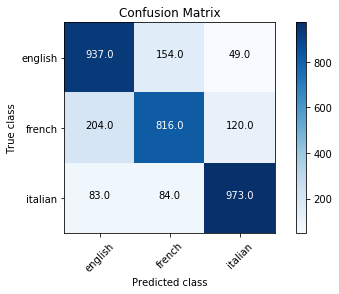

In [89]:
# First we need to obtain the predicted classes
# NOTE: we have already seen how to do it
y_preds = model.predict(x_test_norm)

# Then we can display the confusion matrix
lutil.plot_confusion_matrix(y_test, y_preds, languages)

A confusion matrix is cool because it enables one to see at a glance where most of the classification errors are. In particular:

* Elements on the diagonal correspond to the number of exact classifications: they should be as large as possible.
* Elements outside of the diagonal tell us how many misclassification of each type have occurred.

In our case, for example, we have trouble distinguishing between Italian and French, and some difficulties with French and English.

## Feature Importance Scores

All tree based model enable the computation of "importance scores" for each features, that reflect the average relative reduction in the training metric (e.g. entropy) associated to splits over the feature:

Feature ranking:
1. feature 1 (0.375653)
2. feature 2 (0.309887)
3. feature 0 (0.208676)
4. feature 3 (0.105784)
5. feature 5 (0.000000)
6. feature 4 (0.000000)


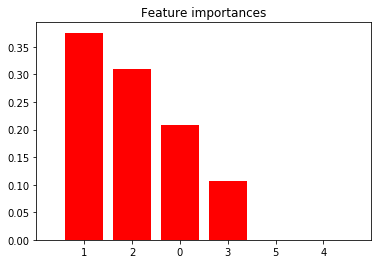

In [94]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

As expected, F1 and F2 are the most important for the classification.

Keep in mind that this information refers to the training set: hence, if a feature is important